In [1]:
import random
from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score
import shutil
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

In [2]:
seed = 42
np.random.seed = seed

IMG_CHANNELS = 3


#uncomment if using linux/macos
#!rm -rf Train Val
#!mkdir Train Val Train/Yes Train/No Val/Yes Val/No

#uncomment if using windows
!rmdir STrain STest /s /q
!md STrain STest STrain\Yes STrain\No STest\Yes STest\No


img_path = 'Dataset/'

input_path = []
target_path = []

for CLASS in os.listdir(img_path): #所有文件
    if not CLASS.startswith('.'):
        all_files = os.listdir(img_path + CLASS)
        files = [item for item in all_files if "img" in item]
        random.shuffle(files) #随机排序
        img_num = len(files)
        for (n, file_name) in enumerate(files):
            img = os.path.join(img_path,CLASS,file_name)
            seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
            seg_name = file_name.split('_')[0]+'_seg.npy'
            
            
            shutil.copy(img, os.path.join('STrain/',CLASS,file_name)) #將源文件的內容複製到目標文件或目錄
            input_path.append(os.path.join('STrain/',CLASS,file_name))
            shutil.copy(seg, os.path.join('STrain/',CLASS,file_name.split('_')[0]+'_seg.npy'))
            target_path.append(os.path.join('STrain/',CLASS,seg_name))

In [3]:
print(len(input_path))
print(len(target_path))

5391
5391


In [4]:
x = np.zeros((len(input_path), 240, 240, 3), dtype=np.float32)
y = np.zeros((len(target_path), 240, 240, 1), dtype=np.float32)

In [5]:
# make x, y are available for model
for n, (file1,file2) in tqdm(enumerate(zip(input_path,target_path))):
    img = np.load(file1)
    mask = np.load(file2)
    mask = mask.reshape(240,240,1)
    x[n] = img
    y[n] = mask

5391it [00:05, 1029.61it/s]


In [6]:
print(x.shape)
print(y.shape)

(5391, 240, 240, 3)
(5391, 240, 240, 1)


In [7]:
from sklearn.model_selection import train_test_split
import gc
# x_test, y_test are used for test the model
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
gc.collect()

(4851, 240, 240, 3) (4851, 240, 240, 1) (540, 240, 240, 3) (540, 240, 240, 1)


22

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)
gc.collect()

(4365, 240, 240, 3) (4365, 240, 240, 1) (486, 240, 240, 3) (486, 240, 240, 1)


0

In [9]:
num_classes = 2

In [10]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [11]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
input_img = Input((240, 240, 3), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

# optimizer, loss function, metrics
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

earlystopping = EarlyStopping(
    monitor='accuracy', 
    mode='max',
    patience=20
)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 240, 240, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 240, 240, 16) 0           batch_normalization_1[0][0]      
______________________

c:\Users\legion\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
# 训练10周期

history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val), callbacks=[earlystopping])


Train on 4365 samples, validate on 486 samples
Epoch 1/10
4365/4365 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.7267

c:\Users\legion\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


4365/4365 [==============================] - 119s 27ms/sample - loss: 0.6275 - accuracy: 0.7267 - val_loss: 0.6267 - val_accuracy: 0.8706
Epoch 2/10
4365/4365 [==============================] - 110s 25ms/sample - loss: 0.4835 - accuracy: 0.9863 - val_loss: 0.4812 - val_accuracy: 0.9875
Epoch 3/10
4365/4365 [==============================] - 113s 26ms/sample - loss: 0.3939 - accuracy: 0.9932 - val_loss: 0.4207 - val_accuracy: 0.9889
Epoch 4/10
4365/4365 [==============================] - 114s 26ms/sample - loss: 0.3039 - accuracy: 0.9936 - val_loss: 0.2965 - val_accuracy: 0.9934
Epoch 5/10
4365/4365 [==============================] - 103s 24ms/sample - loss: 0.2690 - accuracy: 0.9942 - val_loss: 0.2608 - val_accuracy: 0.9937
Epoch 6/10
4365/4365 [==============================] - 104s 24ms/sample - loss: 0.2450 - accuracy: 0.9944 - val_loss: 0.2357 - val_accuracy: 0.9935
Epoch 7/10
4365/4365 [==============================] - 108s 25ms/sample - loss: 0.2253 - accuracy: 0.9946 - val_loss

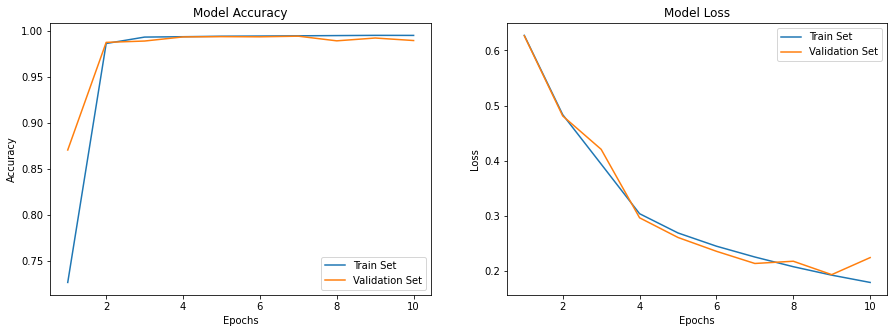

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

In [15]:
model.save('segmentation.h5')

In [16]:
model.evaluate(x_test, y_test, verbose=1)

[0.21507997634234252, 0.99079436]

In [17]:
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_test, verbose=1)

In [18]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)

In [19]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predict')
    ax[2].set_axis_off()
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predict binary')
    ax[3].set_axis_off() 

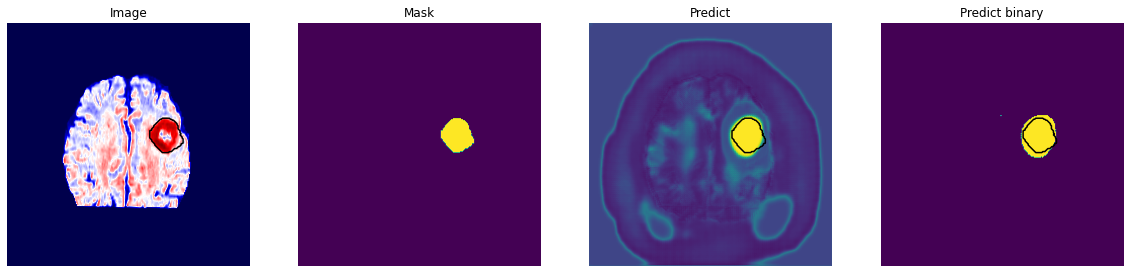

In [20]:
plot_sample(x_test, y_test, preds_val, preds_val_t, ix=14)

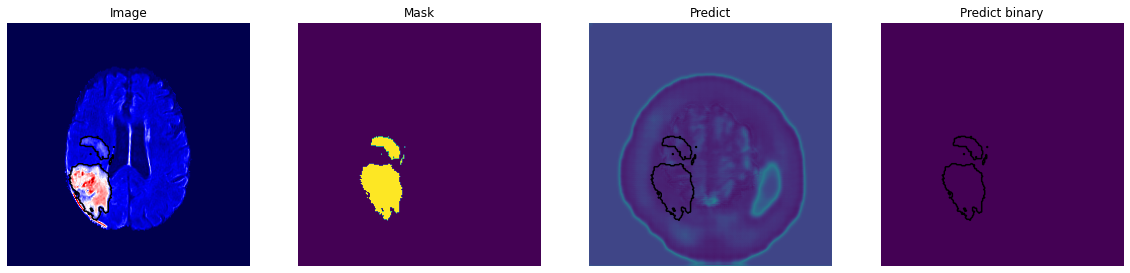

In [21]:
plot_sample(x_train, y_train, preds_val, preds_val_t, ix=17)

## Use the model to predict

In [22]:
model = load_model('segmentation.h5')

In [23]:
path = 'test/imgs/'
test_list = []
all_files = os.listdir(path)
files = [item for item in all_files if "img" in item]
for (n, file_name) in enumerate(files):
    img = os.path.join(path,file_name)
    test_list.append(img)

In [24]:
z = np.zeros((len(test_list), 240, 240, 3), dtype=np.float32)

In [25]:
for n, file1 in enumerate(test_list):
    img = np.load(file1)
    z[n] = img

In [26]:
preds = model.predict(z, verbose=1)

In [27]:
preds_t = (preds > 0.5).astype(np.float32)

In [28]:
!rmdir result /s /q
!md result

for n, (file,file_name) in tqdm(enumerate(zip(preds_t, all_files))):
    name = file_name.split('_')[0]+'_seg.npy'
    np.save("result/"+name, file)

1297it [00:02, 609.47it/s]


In [37]:
def plot_sample(X, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))


    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix,..., 0], cmap='seismic')

    ax[0].set_title('Image')
    ax[0].set_axis_off()

    ax[1].imshow(preds[ix].squeeze(), vmin=0, vmax=1)

    ax[1].set_title('Predicted')
    ax[1].set_axis_off()
    
    ax[2].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)

    ax[2].set_title('binary')
    ax[2].set_axis_off() 

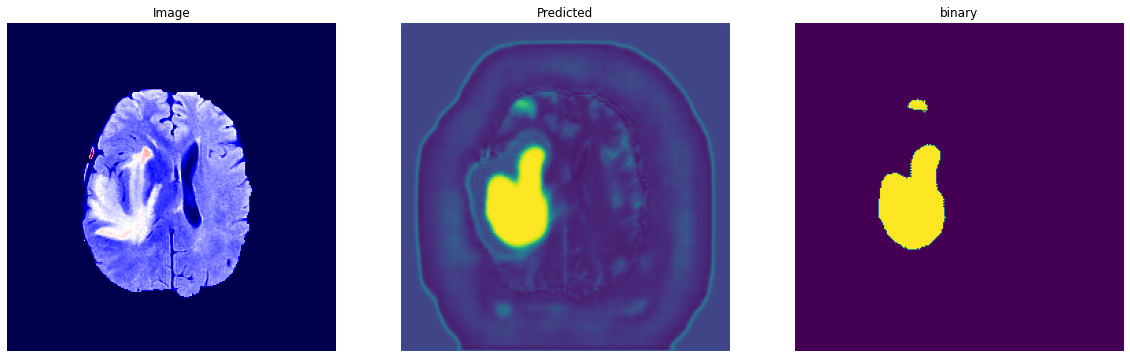

In [53]:
plot_sample(z, preds, preds_t, ix=222)

In [31]:
path2 = 'result/'
list = []
files = os.listdir(path2)
for (n, file_name) in enumerate(files):
    list.append(os.path.join('result/',file_name))
    

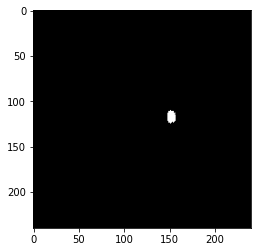

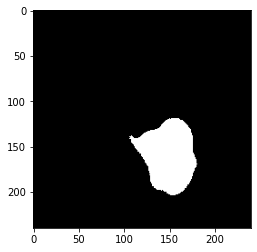

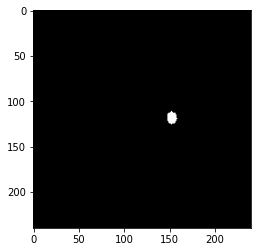

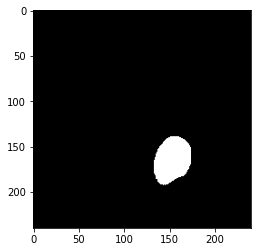

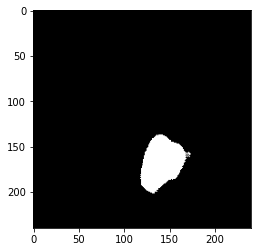

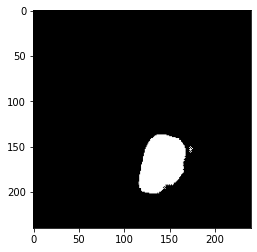

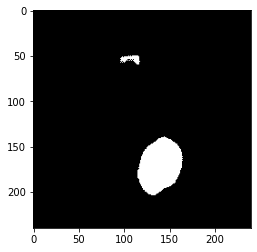

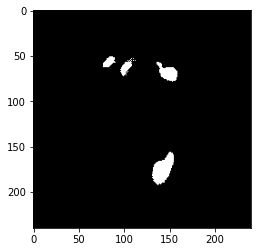

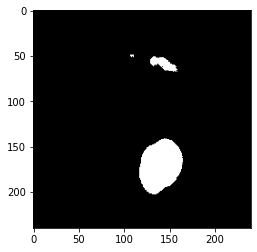

In [32]:
for aa in list[:9]:
    a= np.load(aa)
    plt.imshow(a[:,:], cmap='gray')
    plt.show()